In [1]:
import pandas as pd
import maidenhead as mh
import numpy as np
import os
from datetime import datetime

STATION_CSV = '/usr/datalake/silver/igra/doc/igra2-station-list.csv'
TORNADO_CSV = '/usr/datalake/silver/stormevents/csvfiles/severe_maidenhead.csv'
IGRA_CSV_PATTERN = '/usr/datalake/silver/igra/gph20s10k/{station_id}-data-gph20s10k.csv'
IGRA_MAIDENHEAD_PATH = '/usr/datalake/silver/stormevents/csvfiles/igra_maidenhead'
MAIDENHEAD = 'EN35'
start_date = datetime(2000, 1, 1)
stop_date = datetime(2025, 5, 30)

In [2]:
os.makedirs(IGRA_MAIDENHEAD_PATH, exist_ok=True)

In [3]:
def read_current_stations() -> pd.DataFrame:
    station_df = pd.read_csv(STATION_CSV)
    station_df = station_df[station_df['lst_year'] == 2025]

    return station_df

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, earth_radius=6371.0): # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = earth_radius * c
    return distance

def get_closest_station(lat: float, lon: float, df_source: pd.DataFrame):
    df_distance = df_source.copy()
    df_distance['distance'] = df_distance.apply(lambda x: haversine_distance(x.latitude, x.longitude, lat, lon), axis=1)
    df_distance = df_distance.sort_values(by='distance')

    return df_distance.iloc[0]

def get_severe_in_maidenhead(df_source: pd.DataFrame, in_list: list[str]) -> pd.DataFrame:
    result = df_source.copy()
    result['EFFECTIVE'] = pd.to_datetime(result['EFFECTIVE'])
    result = result[result['MAIDENHEAD'].isin(in_list)]
    result = result.drop(labels=['MAIDENHEAD'], axis=1)
    result = result.groupby(by=['EFFECTIVE']).max()
    result.loc[result['TORNADO_SIGNIFICANT'] == 1, 'SEVERE_SIGNIFICANT'] = 0
    result.loc[result['TORNADO_SIGNIFICANT'] == 1, 'SEVERE_MINOR'] = 0
    result.loc[result['SEVERE_SIGNIFICANT'] == 1, 'SEVERE_MINOR'] = 0

    return result

def merge_temporal_severe(df_source: pd.DataFrame, start: datetime, stop: datetime):
    result = pd.DataFrame(pd.date_range(start, stop), columns=['effective'])
    result = result.merge(df_source, how='left', left_on=['effective'], right_on=['EFFECTIVE'])
    result = result.fillna(0)
    result['TORNADO_SIGNIFICANT'] = result['TORNADO_SIGNIFICANT'].astype(int)
    result['SEVERE_SIGNIFICANT'] = result['SEVERE_SIGNIFICANT'].astype(int)
    result['SEVERE_MINOR'] = result['SEVERE_MINOR'].astype(int)
    result['SEVERE_NONE'] = np.zeros(result.shape[0]).astype(int)
    result.loc[(result['TORNADO_SIGNIFICANT'] == 0) & (result['SEVERE_SIGNIFICANT'] == 0) & (result['SEVERE_MINOR'] == 0), 'SEVERE_NONE'] = 1

    return result

def read_igra_by_id(station_id: str) -> pd.DataFrame:
    filename = IGRA_CSV_PATTERN.replace('{station_id}', station_id)
    result = pd.read_csv(filename)
    result['effective_date'] = pd.to_datetime(result['effective_date'])
    result = result[result['hour']==12]
    result = result.drop(labels=['id', 'hour'], axis=1)

    return result

def merge_severe_igra(df_igra: pd.DataFrame, df_severe: pd.DataFrame) -> pd.DataFrame:
    result = df_igra.merge(df_severe, how='inner', left_on=['effective_date'], right_on=['effective'])
    result = result.drop(labels=['effective'], axis=1)

    return result

In [4]:
station_df = read_current_stations()
station_df.head()

,id,latitude,longitude,elevation,state,name,fst_year,lst_year,nobs
1,AEM00041217,24.4333,54.6500,16.0,NaN,ABU DHABI INTERNATIONAL AIRPOR,1983,2025,41012
10,AGM00060390,36.6899,3.2166,25.0,NaN,DAR-EL-BEIDA,1948,2025,70771
25,AGM00060571,31.6543,-2.2524,808.6,NaN,BECHAR,1949,2025,58801
33,AGM00060630,27.2537,2.5116,268.0,NaN,IN-SALAH,1964,2025,50051
35,AGM00060656,27.7041,-8.1692,443.0,NaN,TINDOUF,1973,2025,14540


In [5]:
lat, lon = mh.to_location(MAIDENHEAD, True)
print (f'Maidenhead {MAIDENHEAD}: ({lat:.2f}, {lon:.2f})')

Maidenhead EN35: (45.50, -93.00)


In [6]:
station_id, station_name = get_closest_station(lat, lon, station_df)[['id', 'name']]
print(f'Closest station: {station_id} {station_name}')

Closest station: USM00072649 CHANHASSEN; MN.


In [7]:
df_igra = read_igra_by_id(station_id)
df_igra.head()

,effective_date,day_num,0_gph,0_pres,0_temp,0_dp,0_u,0_v,1_gph,1_pres,...,19_temp,19_dp,19_u,19_v,20_gph,20_pres,20_temp,20_dp,20_u,20_v
1,2000-01-01,-1.00,288.0,980.2,-3.0,-7.0,1.2,-3.4,688.1,931.9,...,-50.2,-58.0,66.6,0.3,10000.0,260.1,-53.7,-61.4,69.3,0.0
3,2000-01-02,-1.00,288.0,969.5,-2.0,-3.0,-3.5,-3.0,688.1,921.9,...,-54.8,-59.8,31.4,35.2,10000.0,254.7,-53.1,-60.6,34.3,36.6
5,2000-01-03,-1.00,288.0,982.0,-3.9,-7.3,-5.8,-2.1,688.1,933.2,...,-53.5,-58.7,24.5,32.8,10000.0,252.8,-53.4,-62.8,29.7,36.1
7,2000-01-04,-1.00,288.0,982.7,-10.2,-13.0,4.0,-4.7,688.1,932.6,...,-49.6,-76.8,17.4,-7.0,10000.0,246.7,-50.5,-77.5,18.6,-6.3
10,2000-01-06,-0.99,288.0,980.7,-5.7,-10.1,8.2,-3.0,688.1,931.7,...,-50.4,-71.3,39.9,10.0,10000.0,249.5,-50.7,-72.4,40.8,12.5


In [8]:
df_severe = get_severe_in_maidenhead(pd.read_csv(TORNADO_CSV), [MAIDENHEAD])
df_severe = merge_temporal_severe(df_severe, start_date, stop_date)
df_severe = merge_severe_igra(df_igra, df_severe)
print(df_severe.shape)
df_severe.head()

(8218, 132)


,effective_date,day_num,0_gph,0_pres,0_temp,0_dp,0_u,0_v,1_gph,1_pres,...,20_gph,20_pres,20_temp,20_dp,20_u,20_v,TORNADO_SIGNIFICANT,SEVERE_SIGNIFICANT,SEVERE_MINOR,SEVERE_NONE
0,2000-01-01,-1.00,288.0,980.2,-3.0,-7.0,1.2,-3.4,688.1,931.9,...,10000.0,260.1,-53.7,-61.4,69.3,0.0,0,0,0,1
1,2000-01-02,-1.00,288.0,969.5,-2.0,-3.0,-3.5,-3.0,688.1,921.9,...,10000.0,254.7,-53.1,-60.6,34.3,36.6,0,0,0,1
2,2000-01-03,-1.00,288.0,982.0,-3.9,-7.3,-5.8,-2.1,688.1,933.2,...,10000.0,252.8,-53.4,-62.8,29.7,36.1,0,0,0,1
3,2000-01-04,-1.00,288.0,982.7,-10.2,-13.0,4.0,-4.7,688.1,932.6,...,10000.0,246.7,-50.5,-77.5,18.6,-6.3,0,0,0,1
4,2000-01-06,-0.99,288.0,980.7,-5.7,-10.1,8.2,-3.0,688.1,931.7,...,10000.0,249.5,-50.7,-72.4,40.8,12.5,0,0,0,1


<Axes: >

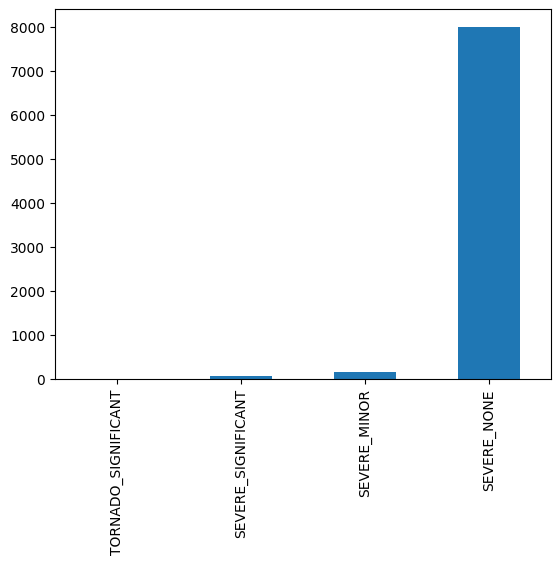

In [15]:
df_severe[['TORNADO_SIGNIFICANT', 'SEVERE_SIGNIFICANT', 'SEVERE_MINOR', 'SEVERE_NONE']].sum().plot(kind='bar')

In [17]:
df_severe.to_csv(f'{IGRA_MAIDENHEAD_PATH}/{MAIDENHEAD}.csv', index=False)